In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import os
from PIL import Image
import shutil


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


## problem

#### The training archive contains 25,000 images of dogs and cats and the test archive contains 12500.
#### we wrote a deep learning algorithm to classify cat/dog in traning and test sets.
#### after creatning the model, we compiled it with **adam** optimization and **binary_crossentropy** loss function, then we fit the model during 20 epochs and the batch_size was 128.
#### at the end we got 96% accuracy on training dataset and 95% accuracy on the test set.

## Detect TPU or GPU

In [2]:
print("Tensorflow version " + tf.__version__)

try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

Tensorflow version 2.4.1
Number of accelerators:  1


## extract data

In [3]:
import zipfile
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
!ls

__notebook_source__.ipynb  test1  train


## see some of the files from train folder

In [5]:
os.listdir('train')[:5]

['dog.10748.jpg',
 'cat.3479.jpg',
 'cat.11866.jpg',
 'dog.4136.jpg',
 'cat.2401.jpg']

## make dataset from train folder

In [6]:
train_image = os.listdir('train')
category = [x.split(".")[0] for x in train_image]
train_df = pd.DataFrame({"filename":train_image, "class":category})
print('the dataset shape is: ',train_df.shape)
train_df.head()

the dataset shape is:  (25000, 2)


,filename,class
0,dog.10748.jpg,dog
1,cat.3479.jpg,cat
2,cat.11866.jpg,cat
3,dog.4136.jpg,dog
4,cat.2401.jpg,cat


## split to train and val dataframe

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
df_train, df_val= train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# df_train = train_df.sample(frac=0.7, random_state=42)
# df_val = train_df.drop(df_train.index)

## see examples from dataset

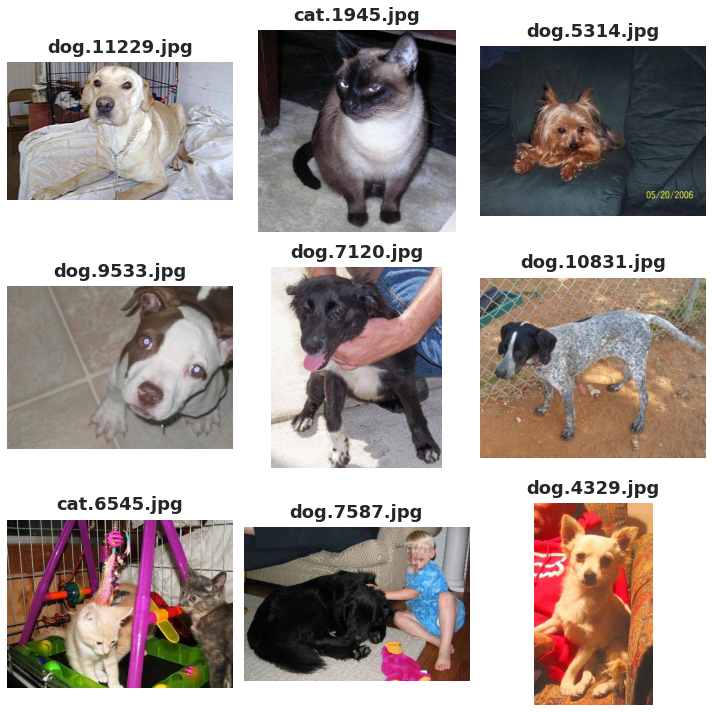

In [8]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    Img = plt.imread('./train/'+df_train.iloc[i,0])
    plt.imshow(Img)
    plt.title(str(df_train.iloc[i,0]))
    plt.axis("off")

## check if the number of dogs and cats is balanced

In [9]:
print(df_train.groupby('class').size())
print(df_val.groupby('class').size())

class
cat    10000
dog    10000
dtype: int64
class
cat    2500
dog    2500
dtype: int64


# preprocessing part
## Data augmentation for train/val dataset using data ImageDataGenerator

In [10]:
train_datagen = image.ImageDataGenerator(
    rotation_range = 15,
    rescale = 1.0/255.0,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

val_datagen = image.ImageDataGenerator(rescale = 1.0/255.0)


# make dataset

batch_size=128
IMG_SIZE=224

train_generator = train_datagen.flow_from_dataframe(df_train, 
                                  directory = "/kaggle/working/train/",
                                  x_col = 'filename',
                                  y_col = 'class',
                                  target_size = (IMG_SIZE, IMG_SIZE),
                                  class_mode = 'categorical',
                                  batch_size = batch_size)

val_generator = val_datagen.flow_from_dataframe(df_val, 
                                  directory = "/kaggle/working/train/",
                                  x_col = 'filename',
                                  y_col = 'class',
                                  target_size = (IMG_SIZE, IMG_SIZE),
                                  class_mode = 'categorical',
                                  batch_size = batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [11]:
train_generator[0][0].shape

(128, 224, 224, 3)

## see an example of preprocessing picture

In [12]:
ex = df_train.sample(1)

ex_generator = train_datagen.flow_from_dataframe(ex,
                                  directory = "/kaggle/working/train/",
                                  x_col = 'filename',
                                  y_col = 'class',
                                  target_size = (224, 224),
                                  class_mode = 'categorical')

Found 1 validated image filenames belonging to 1 classes.


In [13]:
ex_generator[0][0].shape

(1, 224, 224, 3)

shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)
shape of pics is:  (224, 224, 3)


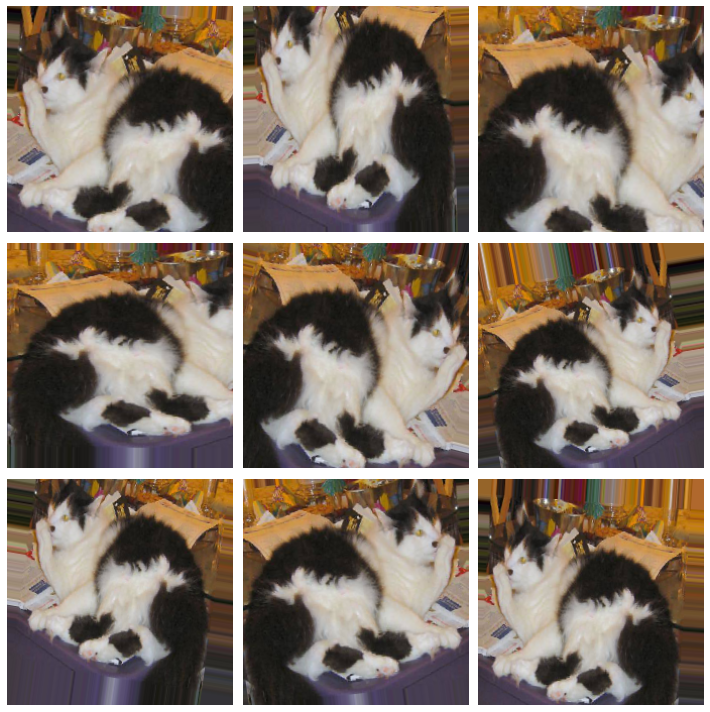

In [14]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in ex_generator:
        image = x_batch[0]
        print('shape of pics is: ',image.shape)
        plt.imshow(image)
        plt.axis("off")
        break
plt.tight_layout()
plt.show()

## create and compile model

In [ ]:
# with tpu_strategy.scope():
    
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(2,activation='sigmoid'))
    
# model = tf.keras.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180,180,3)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(2,activation='sigmoid')
# ])

In [15]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

In [16]:
model.compile(
optimizer=tf.keras.optimizers.Adam(1e-3),
loss="binary_crossentropy",
metrics=["accuracy"],
)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      1

## callbacks = save model+ early stopping

In [18]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

## fit the model

In [20]:
epochs = 20

history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data= val_generator,
    validation_steps = len(df_val)/128,
    steps_per_epoch = len(df_train)/128,
)

Epoch 1/20
156/156 [==============================] - 282s 2s/step - loss: 0.7394 - accuracy: 0.6437 - val_loss: 1.0736 - val_accuracy: 0.5000
Epoch 2/20
156/156 [==============================] - 279s 2s/step - loss: 0.5401 - accuracy: 0.7413 - val_loss: 1.5332 - val_accuracy: 0.5004
Epoch 3/20
156/156 [==============================] - 279s 2s/step - loss: 0.4285 - accuracy: 0.8090 - val_loss: 1.1178 - val_accuracy: 0.5334
Epoch 4/20
156/156 [==============================] - 279s 2s/step - loss: 0.3369 - accuracy: 0.8568 - val_loss: 0.3106 - val_accuracy: 0.8712
Epoch 5/20
156/156 [==============================] - 280s 2s/step - loss: 0.2835 - accuracy: 0.8796 - val_loss: 0.2788 - val_accuracy: 0.8818
Epoch 6/20
156/156 [==============================] - 279s 2s/step - loss: 0.2368 - accuracy: 0.9022 - val_loss: 0.2895 - val_accuracy: 0.8776
Epoch 7/20
156/156 [==============================] - 278s 2s/step - loss: 0.2120 - accuracy: 0.9125 - val_loss: 0.4781 - val_accuracy: 0.8088

## visualize the training

<AxesSubplot:>

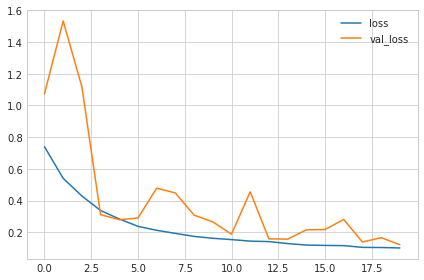

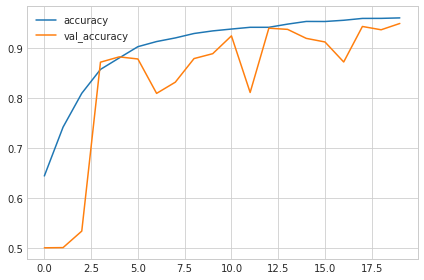

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

## preparing the test dataset

In [25]:
test_images = os.listdir("/kaggle/working/test1")
df_test = pd.DataFrame({'filename':test_images})
df_test.head()

,filename
0,10885.jpg
1,6624.jpg
2,9149.jpg
3,9634.jpg
4,8491.jpg


## create test dataGen

In [29]:
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory = "/kaggle/working/test1/",
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False
)

Found 12500 validated image filenames.


## prediction on the test set

In [30]:
test_predictions = model.predict(test_generator)

In [31]:
test_predictions[:5]

array([[9.9955875e-01, 4.4125775e-04],
       [1.0000000e+00, 6.9859718e-09],
       [1.0000000e+00, 3.0258938e-11],
       [2.6039963e-03, 9.9739599e-01],
       [8.6060125e-01, 1.3939881e-01]], dtype=float32)

## complete the test dataFrame based on predictions

In [35]:
label_p = np.argmax(test_predictions,axis=1)
cat=[]
for i in label_p:
    if i==0: cat.append('cat')
    else: cat.append('dog')
df_test['category'] = cat
df_test.head()

,filename,category
0,10885.jpg,cat
1,6624.jpg,cat
2,9149.jpg,cat
3,9634.jpg,dog
4,8491.jpg,cat


## see some prediction example with pics

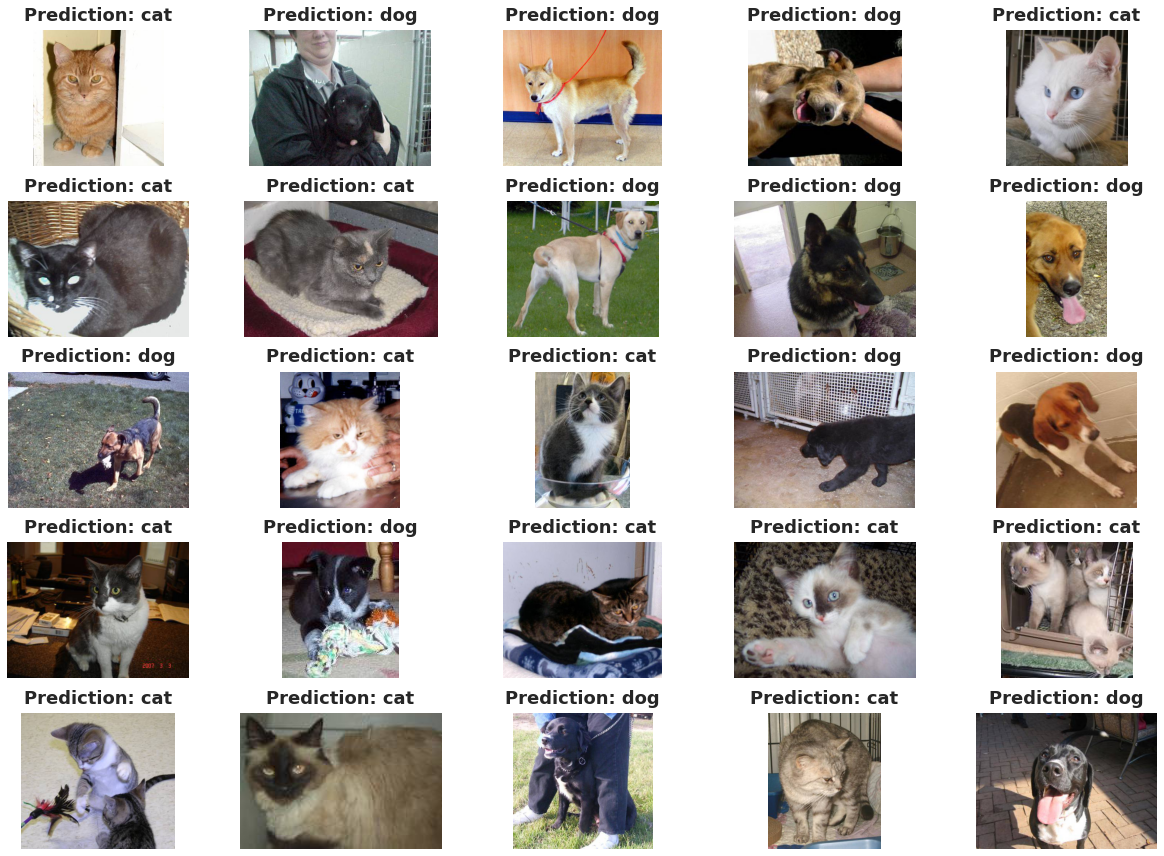

In [40]:
df_example = df_test.sample(25).reset_index(drop=True)

plt.figure(figsize=(18,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    filename = df_example['filename'][i]
    category = df_example['category'][i]
    image = load_img('/kaggle/working/test1/'+filename)
    plt.imshow(image)
    plt.title(f"Prediction: {category}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## evaluate model on the validation set

In [41]:
model.evaluate(val_generator)

40/40 [==============================] - 20s 495ms/step - loss: 0.1211 - accuracy: 0.9486


[0.12109455466270447, 0.9485999941825867]

## pie chart for test predictions

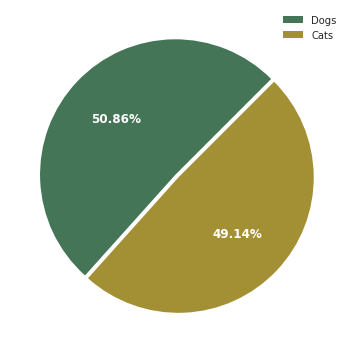

In [49]:
plt.figure(figsize=(5,5))
plt.pie(df_test['category'].value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#447557', '#A49034'])
plt.legend(["Dogs","Cats"])
plt.show()